# ANALYTICS

This notebook allows to analyse the logs recorded when running the hyperparamter experiments.

*IMPORTANT REQUIREMENT*: logs are expected to be saved in the following directory: ``./results/<dataset>`` without changing the given name ``<algo>_<net>_<iteration>.csv``. Furthermore logs issued from fast runs with only 80 models instead of the standard 250 (25 configurations, 10 iterations) should be placed in the subfolder ``./results/<dataset>/FAST`` and the runs using ``ray.tune`` in the subfolder ``./results/<dataset>/TUNE``.

In [21]:
import pandas as pd
from numpy import genfromtxt
import numpy as np
from scipy.interpolate import *
import matplotlib.pyplot as plt
import math
import os

In [22]:
def fonc(data):
    itera = data[:,5:6]
    itera= itera[~np.isnan(itera)]
    dat = data[:,0:2]
    dat = dat[~np.isnan(dat)]
    dat = dat.reshape(-1,2)
  #  dat = dat[np.argsort(itera,axis=-1)]
    return dat

In [23]:
def maxof(a, n_elem):
    ma = 0
    ta = 0
    for i in range(n_elem+1):
        if(a.shape[0]<=i):
            a=np.concatenate((a,(np.array([np.array([ma,ta])]))))
        else:
            if(ma<a[i,0]):
                ta = a[i,1]
            ma = max(ma,a[i,0]) 
            a[i,0] = ma
            a[i,1] = ta
    return a[:n_elem] 

In [24]:
def iteration_corector(liste, num_config):
    for i in range(len(liste[:])):
        liste[i] = math.floor(i/num_config)

In [25]:
def getall(a):
    f = [b for b in a[:,1::2].mean(1)]
    g = [b for b in a[:,0::2].mean(1)]
    return (f, a[:,1::2].std(1)/2, g,
                a[:,0::2].std(1)/2)

In [26]:
def get_color(algo: str):
    algo_colors = {
        "RAND": (0.5, 0.5, 0.5),
        "BAYES": (1, 0.4, 1),
        "BOHB": (0, 0, 1),
        "PBT": (1, 1, 0),
        "PB2": (1, 0, 1),
        "GPBT": (0, 1, 1),
        "HEBO": (1, 0, 0),
        "GPBTHEBO": (0, 1, 0),
    }
    return algo_colors[algo]

In [27]:
def get_time(algo: str, fast=False):
    if fast:
        algo_times = {
            "RAND": 480,
            "BAYES": 450,
            "BOHB": 350,
            "PBT": 400,
            "PB2": 405,
            "GPBT": 420,
            "HEBO": 260,
            "GPBTHEBO": 420,
            
        }
    else:
        algo_times = {
            "RAND": 480,
            "BAYES": 450,
            "BOHB": 350,
            "PBT": 400,
            "PB2": 405,
            "GPBT": 1,
            "HEBO": 1,
            "GPBTHEBO": 1500,
        }
    return algo_times[algo]

In [28]:
def analyse_result_files(algo, model, num_iteration, filepath, val, N, tune):
    algo_results = []
    for iteration in range(num_iteration):
        filename = algo + "_" + model + "_" + str(iteration) + ".csv"
        filename = os.path.join(filepath, filename)
        logs = genfromtxt(filename, delimiter=",")
        if tune:
            test_loss = fonc(logs)
        else:
            test_loss = logs[np.argsort(logs[:, -5], axis=-1, kind="stable")][:, -2:]
        test_loss = maxof(test_loss[:, ::], N)
        algo_results.append(test_loss)
    [mean_test, std_test, mean_val, std_val] = getall(np.concatenate(algo_results, axis=1))
    if val:
        mean, std = mean_val, std_val
    else:
        mean, std = mean_test, std_test
    time = np.arange(0, N) * get_time(algo, (N == 80)) / N
    label = algo
    if N == 80:
        label = algo + "_80"
    plt.plot(time, mean, color=get_color(algo), label=label)
    plt.fill_between(time, mean - std, mean + std, alpha=0.2, color=get_color(algo))



def process(dataset: str, algos = ["RAND"], fast_algos = [], tune_algos=[], model = "LeNet", num_iteration=10, val=False, ymin=0.6, ymax=1, xmin=0, xmax=600):
    for algo in algos:
        path = os.path.join( "./results", dataset)
        analyse_result_files(algo, model, num_iteration, path, val, 250, False)
    for algo in fast_algos:
        path = os.path.join( "./results", dataset, "FAST")
        analyse_result_files(algo, model, num_iteration, path, val, 80, False)
    for algo in tune_algos:
        path = os.path.join( "./results", dataset, "TUNE")
        analyse_result_files(algo, model, num_iteration, path, val, 250, True)
    
    axes = plt.gca()
    axes.set_ylabel("accuracy", fontsize=12)
    axes.set_xlabel("execution time (s)", fontsize=12)
    axes.set_ylim(ymin,ymax)
    axes.set_xlim(xmin,xmax)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.legend()
    if val:
        filename = dataset + "_" + "val.png"
    else:
        filename = dataset + "_" + "test.png"
    plt.savefig(filename)

## Examples
To obtain accuracy plots, just ran the process function specifiying the required parameters as in the below exemples:

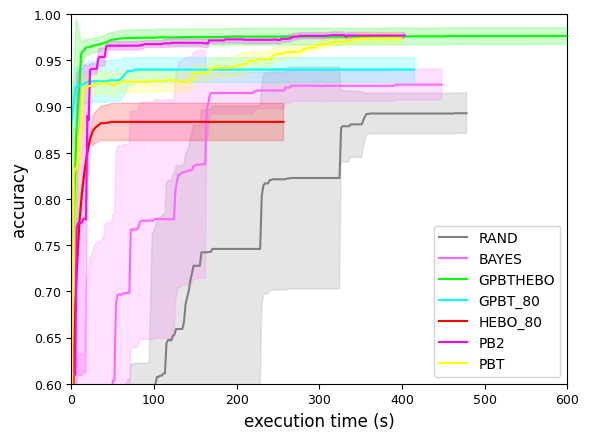

In [31]:
process(dataset="MNIST", algos=["RAND", "BAYES", "GPBTHEBO"], fast_algos=["GPBT", "HEBO"], tune_algos=["PB2", "PBT"], ymin=0.6, val=False)

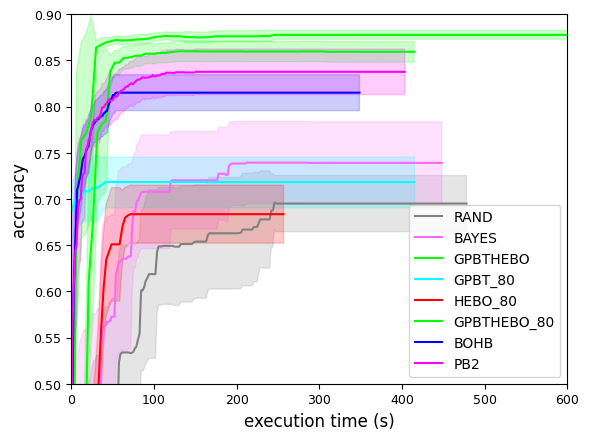

In [32]:
process(dataset="FMNIST", algos=["RAND", "BAYES", "GPBTHEBO"], fast_algos=["GPBT", "HEBO", "GPBTHEBO"], tune_algos=["BOHB", "PB2"], ymax=0.9, ymin=0.5, val=False)